# MT3510: Applied Project - Team 12

## Introduction

### The Problem

### The Method

### Report Layout
Parts are divided into their own sections containing the code, description of the implementation and results

### Code Imports

In [11]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Imports for output formatting
from IPython.display import Markdown as md
from IPython.display import display

#Part 2 Imports
import sympy as sp
from sympy.plotting import plot

# Part 3 Imports
from ipywidgets import interact,interactive, fixed

#Part 4 Imports
from time import process_time
from scipy.interpolate import CubicSpline
import bisect

## Part 1

In [12]:
#Part 1 Function creation in this cell

#Modelled from MT3510 Lecture Notes (Chapter 3: Interpolation Part 3)
def piecewiseLagrange(degree,knots,evalPoints):
    M = int(knots.size/2)
    N = evalPoints.size
    x0 = knots[0]
    y0 = knots[1]
    
    #---Calculate Interpolants---
    Nint = M - degree #M - degree interpolants to obtain
    pts = np.arange(degree+1) + np.arange(Nint).reshape(Nint,1) #get required set of points
    
    a = np.zeros((degree+1,Nint)) #creates array to store coefficients
    
    #Loops over possible interpolants, finding coefficients by solving Vandermode matrix
    for i in range(Nint): 
        A = np.vander(x0[pts[i,:]])
        a[:,i] = np.linalg.solve(A,y0[pts[i,:]])
    
    #---Choose which interpolants to use (assuming uneven spacing)---
    y = np.empty_like(evalPoints)     # set up new data points
    pows = degree-np.arange(degree+1)

    for i in range(N):# loop over new evaluation points
        if((evalPoints[i]<x0).all()): # if we're outside of the interval, set k to extrapolate
            k = 0
        elif((evalPoints[i]>x0).all()):
            k = M-1
            
        else:# find k for x_i, accounting for the possibility that x_i=x_k
            k = np.where(((evalPoints[i]<x0[1:]) & (evalPoints[i]>=x0[:-1])) | 
                         ((x0[1:]==evalPoints[i]) & (evalPoints[i]>x0[:-1])))[0][0]

        # account for j being at the edge
        j = k - degree//2    
        j = max(0,j)
        j = min(j,Nint-1)

        y[i] = np.sum(a[:,j]*evalPoints[i]**pows)  # obtain new data point

    return y

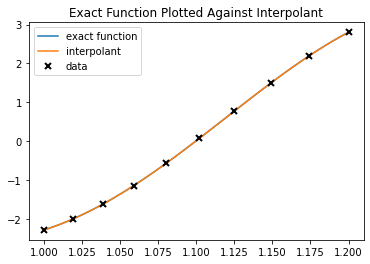

In [13]:
# Part 1 Function Testing in this cell
def f(x):
    return np.exp(x)*np.cos(10*x)

N = 10
r0 = np.linspace(0,1/6,N)

x1 = 1/(1-r0) # coordinate transformation to test uneven spacing
y1 = f(x1)

knots = np.array([x1,y1])
degree = 4
evalPoints = np.linspace(x1[0],x1[-1],40) # knots range (1,1.2)
interpolant = piecewiseLagrange(degree,knots,evalPoints)

plt.plot(evalPoints,f(evalPoints),label = 'exact function')
plt.plot(evalPoints,interpolant,label='interpolant')
plt.plot(x1,y1,'kx',mew=2,label='data')
plt.title('Exact Function Plotted Against Interpolant')
plt.legend()
plt.show()

## Part 2

### Introduction
The code iterates over a range of polynomial degrees and values of N or h, computes the maximum error for each combination, and plot the error- vs -$h^{n}$ for each degree of polynomial. 

We are also able to check the rate of convergence from the error data. This allows us to understand how the accuracy of the interpolation changes as we vary the degree of the polynomial and the number of data points, hence decide on the appropriate ones. 


### Method 
In this project we used piecewise Lagrange interpolation. Compared with (Piecewise) Linear interpolation, high order polynomials improve the accuracy of the approximation. Compared with general polynomial interpolation, piecewise method minimize the detrimental effect of increasing derivatives (which will be discussed in 7.1). A better method as we discussed in the lecture is Cubic Spline interpolation which has better smoothness (as it is continious to second derivative) and reduce overfitting. Other method include, rational function method, which involves approximating a function using a ratio of two polynomials.

### Implementation
#### Tune the choice of Evaluation Points N
When N is small, which means that h is large, there's large volotility in the error trend. So we choose the a realtively large N = 1000 to ensure a smooth trend. 
***
`N_eval = 1000
evalPoints = np.linspace(x_start, x_end, N_eval)`
***



#### Loop over Degree & Interval

Create an empty 2D array max_error to store the maximum error for each degree of polynomial and N or h.
***
`max_error = np.zeros((len(deg_range), len(N_range)))`
***

We use a nested loop to calculate the maximum error for each degree of polynomial and h. The outer loop iterates over the range of degrees of polynomial tested, while the inner loop iterates over the range of h. For each combination of degree of polynomial and h, the code constructs a set of knots using evenly spaced data, interpolates the function using piecewise Lagrange method, and computes the maximum error between the interpolated function and the true function over a set of evaluation points.

***
`for i, deg in enumerate(deg_range):
    for j, h in enumerate(h_range):
        ...`
***

#### Code

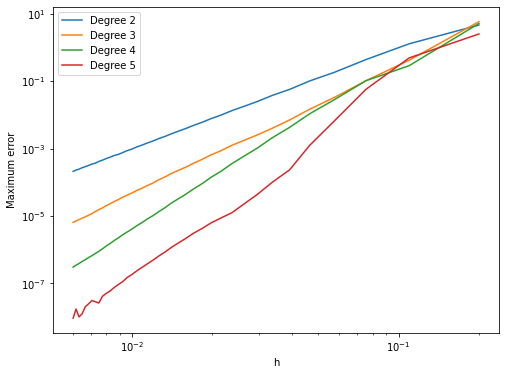

In [14]:
#Part 1 Function creation in this cell

# Define the subinterval and evaluation points
x_start = 1
x_end = 2.8
N_eval = 1000
evalPoints = np.linspace(x_start, x_end, N_eval)
y1 = f(evalPoints)

# Degrees of polynomial 
deg_range = range(2, 6)

# Range of  of N or h
N_range = np.linspace(10, 300, 40)
h_range = (x_end - x_start) / (N_range - 1)

# Maximum error 
max_error = np.zeros((len(deg_range), len(N_range)))

# Calculate the maximum error for each degree of polynomial and N or h
for i, deg in enumerate(deg_range):
    for j, h in enumerate(h_range):
        N = int((x_end - x_start) / h) + 1
        x0 = np.linspace(x_start, x_end, N)
        y0 = f(x0)
        knots = np.array([x0,y0])
        y_interp = piecewiseLagrange(deg, knots, evalPoints)
        max_error[i, j] = np.max(np.abs(y1 - y_interp))

# Plot the error vs. h for each degree of polynomial
plt.figure(figsize=(8, 6))
for i, deg in enumerate(deg_range):
    plt.loglog(h_range, max_error[i], label=f'Degree {deg}')
plt.xlabel('h')
plt.ylabel('Maximum error')
plt.legend()
plt.show()

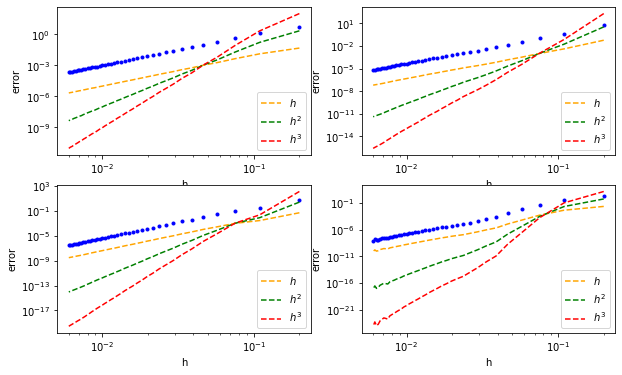

In [15]:
# Plot the maximum error againt h, h^2 and h^3 to ensure we have the predicted trend 
fig, axs = plt.subplots(2, 2, figsize=(10, 6))


# Define the degrees of polynomial and corresponding colors for plotting
degrees = [2, 3, 4, 5]
colors = ['orange', 'green', 'red','blue']

# Loop over the degrees of polynomial and plot the subplots
for i, deg in enumerate(degrees):
    row = i // 2  # Determine the subplot row position 
    col = i % 2   # Determine the subplot column position
    ax = axs[row, col]
    ax.loglog(h_range, max_error[i], '.', color=colors[3])
    ax.loglog(h_range, 0.01*max_error[i], '--', label='$h$', color=colors[0])
    ax.loglog(h_range, 0.1*max_error[i]**2, '--', label='$h^2$', color=colors[1])
    ax.loglog(h_range, max_error[i]**3, '--', label='$h^3$', color=colors[2])
    ax.set_xlabel('h')
    ax.set_ylabel('error')
    ax.legend()

plt.show()


### Results

#### Description

The maximum error on a log-log plot fit in our expectation

As the number of points N used for interpolation increases, h decreases, leading to a higher accuracy (decrease of error) of the interpolation, which is also known as convergence of the method. 

Also, assuming the size of derivative is small, as the order of polynomial increases, the interpolation function fit the original function more accurately.

The slope of Degree 5 Polynomial is 5.3004 which is close to the expected convergence rate of 5 (degree of polynomial). 

In [16]:
# Calculate the slope of the log-log plot for each degree of polynomial
for i, deg in enumerate(deg_range):
    # Select the range of data points to fit
    fit_range = range(5, len(h_range))
    # Fit a line to the data points in log-log scale
    coeffs = np.polyfit(np.log(h_range[fit_range]), np.log(max_error[i, fit_range]), 1)
    slope = coeffs[0]
    print(f'Degree {deg}: slope = {slope:.4f}')

Degree 2: slope = 3.0100
Degree 3: slope = 3.7838
Degree 4: slope = 5.1519
Degree 5: slope = 5.3004


#### Discussion 
##### Detrimental effect of higher order polynomial

We make the assumption that the derivative is small when fitting with higher order polynomial, which may not be the case here, as the derivative grows dramtically after the fourth derivative. Fitting with higher order polynomial can lead to oscillations and overfitting, especially near the edges of the interpolation interval, as shown from the trend of Deg 5 Polynomial.

## Part 3

### Introduction
In part three, an interactive plot was produced to make it easy to see how the interpolated function fits to the same knots for different degrees of Lagrange Polynomial. The values of the knots for this task were arbitray as its aim was to show pictorially how good the fit of polynomial was for different degrees . Hence, to make coding more simple, it was chosen to have evenly spaced knots. To make the plot interactive it was decided to use the interactive widget with a pre-stated plotting function and then introduce a slider. This had the advantage that it was easy to add another silder into the function if investigating the change in another variable was desirable.

### Implementation 
The plotting function created calculated the x knots and f(x knots) as well as using array broadcast to find the y values of interpolated function evaluated at a set of x points. The function took five variables, the lowest and highest values of the interval wanting to investigate, the degree of polynomial, the number of knots desired and the number of evaluation points desired. The code for this section could be loosely based on an example in the lecture notes Chapter Three part 2. Within the plotting function, subplots were then created, the first showed the knots joined together by straight lines. The graph was shown on a fixed axis scale to make it easier for the viewer to visualise the changing polynomial relative to the knotted function. On the same subplot, a lagrange polynomial of a degree to be specified by a slider was shown. A second subplot showing the error in the lagrange polynomial compared to the exact function f(x) was added, allowing the viewer to observe an increase or derease in accuracy with increased degree.

### Code

In [8]:
# Defining function to plot graphs showing interpolated function and knots 
# as well as error in interpolated function
def plotting(low, high, Degree, Nknot, Neval):

    x_knots = np.linspace(low, high, Nknot)  #Setting arbitary knots in specifed function range
    y_knots = f(x_knots)  #Finding f(x) using x knots
    
    
    # Finding the points over which want to interpolate, MM is number of points will need for interpolation
    MM = Degree+1
    start = int((Nknot-MM)/2)        # Ensuring points in interpolation are near centre of knots
    pts = np.arange(start,start+MM)

                   
    A = np.vander(x_knots[pts[:]])          # constructing the Vandermode matrix
    a = np.linalg.solve(A,y_knots[pts[:]])  # obtain the coefficients by solving the system

    pows = (Degree-np.arange(MM)).reshape(MM,1)         # these are the exponents required

    x = np.linspace(low,high, Neval)   # x evaluation points

    # Finding the interpolated y values
    xnew = np.reshape(x,(1,Neval))                         # reshape for the broadcast
    ynew = np.sum((xnew**pows)*a.reshape(MM,1),axis=0) # multiply by coefficients and sum along the right direction
    
    
    # Plotting the knots and interpolated function
    fig, (ax1, ax2) = plt.subplots(2, figsize = (8,6))
    fig.tight_layout(h_pad=4)
    ax1.set_ylim(-7, 10)     # Ensuring axis stay constant
    
    # plot connection between knots in red
    ax1.plot(x_knots, y_knots, color="red", label="f(x) showing knots joined together")
    ax1.plot(x_knots, y_knots,'kx',mew=2,label='knots')

    # plot interpolated function as dashed blue line
    ax1.plot(x, ynew, color="b", linestyle='--', linewidth=3, label="Interpolated function")

    # Labels
    ax1.legend()
    ax1.set_title("Comparison of joined knots and interpolated data");
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")
    
    # Plotting second plot showing error in green
    ax2.plot(x, np.abs(f(x)-ynew), color="g", linewidth=2, label="Error in interpolated polynomial")
    
    # Labels
    ax2.set_title("Plot showing error in interpolated polynomial $|f(x)-p_{degree}(x)|$ at evaluation points x");
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")

In the cell below, an interactive plot of the given function $f(x)=e^xcos(10x)$ on 11 knots is coded.

In [9]:
# Specifying number of knots to ensure slider on correct interval
number_of_knots = 11

# Making plots interactive for the degree variable
interactive(plotting,
            low = fixed(1),
            high = fixed(2),
            Nknot = fixed(number_of_knots),
            Degree = (1,(number_of_knots-1)),
            Neval = fixed(30))

interactive(children=(IntSlider(value=5, description='Degree', max=10, min=1), Output()), _dom_classes=('widge…

### Results Discussion

It can be seen from the resultant plots for the function $f(x)=e^xcos(10x)$ on 11 knots, that as the degree of polynomial increases, so to does the blue line of the polynomial fit appear to follow the red line joining the knots. If we then look to the error plot, this trend can be seen by the decrease in error with increasing polynomial degree meaning that the fit is more like the function f(x) we expect to see. It should be noted that though the error decreases with increased polynomial degree, once we get to degree 10 where all knots are included in the function, the error is pushed out towards the edges in an effect called Runge's Phenomenon. To overcome this error on the outer reaches of the fit, piecewise interpolation is used, where many smaller degree of polynomials are fitted together to create one large and more accurate approximation to the function.

## Part 4

In [10]:
# import data

data = np.loadtxt("wave_data1.txt")
[times, elev] = data

OSError: wave_data1.txt not found.

### Part 4.1
*How many data points appear to be missing?*

#### Code

In [ ]:
# First find missing points

# We see that the times recorded are t in [0.1,30] in steps of 0.1

comtime = np.arange(0.1,30.1,0.1) # Create an array of the complete times

# Use sets to efficiently find the data points missing. 
# Need to round arrays to one decimal place for this to work

set_time = set(times.round(1))
set_comtime = set(comtime.round(1))

missingSet = set_comtime - set_time  # Find elements missing from time set

missingArr =  np.array(list(missingSet)) # convert to np.array 
missing = missingArr[np.argsort(missingArr)] # order the missing points

display(md("We are missing {} data points at times {} s.".format(len(missing), list(missing))))

#### Implementation

Explaining the use of sets:

We improve efficiency by using sets instead of for loops and arrays to calculate the missing elements in the array times. Using sets also simplifies our code, making it easier to understand and less prone to errors.

If we used for loops and arrays, we would need to iterate through each element in both arrays to compare them. This would result in a time complexity of $O(n^2)$, where n is the number of elements in the arrays. Instead we coverted the arrays into sets and subtracted one from another. This operation has a time complexity of $O(n)$. Hence improving efficiency.

### Part 4.2
*Use your interpolation function from part 1 to obtain a new uniformly sampled data set on 0.01s 
subintervals for the first 20s using piecewise cubic polynomials. Plot the new data alongside 
the equivalent data obtained using scipy.interpolate.CubicSpline*

#### Code

In [ ]:
s_time = np.arange(0.01,20.01,0.01) # Create array of times in [0.01,20]s at 0.01s intervals

# Interpolate using scipy

cs = CubicSpline(times, elev, bc_type = 'natural')
ySpline = cs(s_time)

# Using piecewiseLagrange 

degree = 3
PWL = piecewiseLagrange(degree,data,s_time)

# Plotting

fig = plt.subplots(figsize=(6,5))

plt.plot(s_time,PWL,label = 'PWL', lw=1)
plt.plot(s_time,ySpline,label='scipy CubicSpline',lw=1)

plt.title(r"""Fig 4.2. Comparing piecewiseLagrange with scipy.interpolate.CubicSpline for the first 20s of wave data""") 
plt.xlabel("Time (s)")
plt.ylabel("Elevation (m)")

plt.grid()
plt.tight_layout()
plt.legend()
plt.show()

### Part 4.3
*Plot the difference between the piecewise cubic interpolation 
and the cubic spline interpolation obtained using scipy.interpolate.CubicSpline*

#### Code

In [ ]:
# Calculating the difference/'error' between our method and CubicSpline

errors = abs(PWL-ySpline) 

fig = plt.subplots(figsize=(5,4))

plt.plot(s_time,errors,lw=1)

plt.title("Fig 4.2. The error |PWL(x) - CubicSpline(x)| for the first 20s of wave data") 
plt.xlabel(" Time (s)")
plt.ylabel("Error (m)")
plt.grid()
plt.tight_layout()
plt.show()

#### Discussion
The maximum error peak and another large peak occur around the missing data points of 
14.1-14.3s and 10.1-10.4s respectively. This is to be expected as the missing data points result in a larger interval for the spanning cubic interpolant (four and five times longer respectively).

#### Part 4.4: Futher Investigation

##### 4.4.1 
*Finding the value of the maximum 'error' and the time at which it occurs*

In [ ]:
errMax = np.max(errors) # Find max error

errMax_indx = np.where(errors == errMax) # Find index of max error
errMax_time = s_time[errMax_indx][0] # Find time of max error

display(md(""" The largest error of **{:e} m** occurs at {} s.""".format(errMax, errMax_time)))

##### 4.4.2
*Comparing the 'missing value data' and the value of the corresponding 'errors'*

In [ ]:
def zoomPlot(zoom_coords):
    
    """ Function for: (1) visualising the: wave data, scipy.CublicSpline & PWL in the same plot,
    (2) plotting the 'error' between scipy.CublicSpline & PWL and (3) then focusing on an x-range 
    (specified by 'zoom_coords') of interest. """
    
    [z1,z2] = zoom_coords
    
    global times, elev, s_time, ySpline, PWL, errors, missing
    
    
    fig,(ax2,ax3) = plt.subplots(ncols = 2, figsize=(18,8))
    
    ax2.plot(s_time, PWL, label = 'PWL', lw = 1, color='blue')
    ax2.plot(s_time,ySpline,label='CublicSpline', lw = 1, color = 'green')
    ax2.plot(times, elev, label = 'Wave data', lw = 1, color='orange')
    
    ax2.set_xlim(z1,z2)
    
    ax2.set_xlabel(r"Time [s]")
    ax2.set_ylabel(r"Elevation [m]")
    ax2.set_title(r"""Fig 4.4.2.2 Comparing Wave data, CublicSpline and PWL 
on the zoom interval [{}s, {}s] """.format(z1,z2))

    ax2.tick_params(axis = 'both')
    ax2.grid()
    ax2.legend()
    
    
    ax3.plot(s_time, errors,lw = 1, color='r',label='Errors')

    indx = np.where(s_time == missing[0])[0][0]
    ax3.scatter(missing[0],errors[indx],color='blue',s=20, label='missing data pts',zorder=5)
    ax3.annotate(' {}'.format(missing[0]),[missing[0],errors[indx]])
    
    for i in missing[1:]:
        indx = np.where(s_time == i)[0][0]
        ax3.scatter(i,errors[indx],color='blue',s=20,zorder=5)
        ax3.annotate(' {}'.format(i),[i,errors[indx]])

    ax3.axvline(z1,ls='--',lw =1, color='grey', label = 'zoom window')
    ax3.axvline(z2,ls='--',lw =1, color='grey')
    ax3.set_xlabel(r"Time [s]")
    ax3.set_ylabel(r"Error [m]")
    ax3.set_title(r"""Fig 4.4.2.3. Error, | PWL - scipy.CubicSpline | on the time interval [0, 20s] with
the missing time points are shown.""")

    ax3.tick_params(axis = 'both')
    ax3.grid()
    ax3.legend()
    
    plt.tight_layout(pad=3)
    
    plt.show()
    
zoomPlot([13.7,14.7])

The maximum error occurs at 14.16s because:

(1) CubicSpline uses Hermite polynomial scheme for the interpolation and hence will typlically involve higher order polynomials than the Lagrange interpolation. Hence the the peaks and troughs will be more extended (stretched) in the Hermite case. The effect is more exaggerated with the longer time interval.

(2) The diffference between adjacent interpolants increases with time and as a result the second region of missing points has a larger error.

The combined effect of (1) and (2) produces an error spike with it's peak approximately at
the centre of the extended interval of 14.0 - 14.4s.

## Conclusion

## Who Did What?

In the first meeting of the group, it was discovered that one member had taken a leave of abcense from the university so there were only five team members. It was then decided to split the workload such that Josh completed part 1, Kerry part 2, Isobel part 3 and Will and James would work together on part 4 - which we jugded at first viewing to be the most difficult section. Josh was nominated as the liason to Dr Lucas as he would be finished his section first, as other sections relied on its results. Each person or pair was to write any accompanying text to the code that they had written and Josh would be in charge of collating the sections.